In [ ]:
#Data preprocessing
import string
import numpy as np
import pandas as pd

#Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Natural language processing and encoding techniques
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Splitting dataset into train,test and validation
from sklearn.model_selection import train_test_split

#Tokenizing and padding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Building LSTM model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv('/content/tweets.txt',names=["Tweet","Emotion"],sep=";")

# Data Analysis

In [ ]:
df

,Tweet,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness
19996,i constantly worry about their fight against n...,joy
19997,i feel its important to share this info for th...,joy
19998,i truly feel that if you are passionate enough...,joy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    20000 non-null  object
 1   Emotion  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [ ]:
df.shape

(20000, 2)

In [ ]:
df.isnull().sum()

,0
Tweet,0
Emotion,0


In [ ]:
df.duplicated().sum()

1

In [ ]:
df.duplicated(subset=["Tweet"]).sum()

52

In [ ]:
Emotion_counts = df["Emotion"].value_counts()
print(Emotion_counts)

Emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


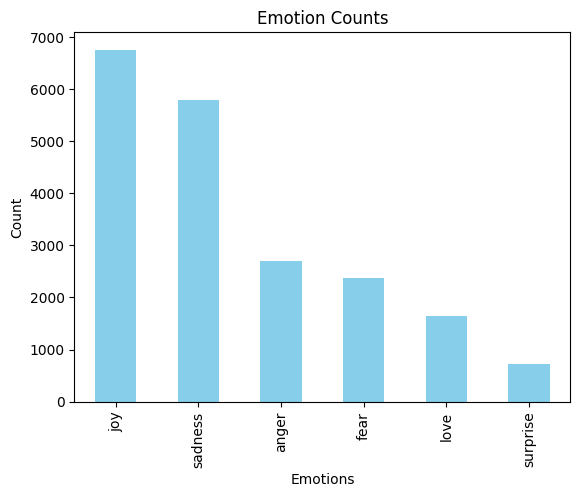

In [ ]:
Emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Counts')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

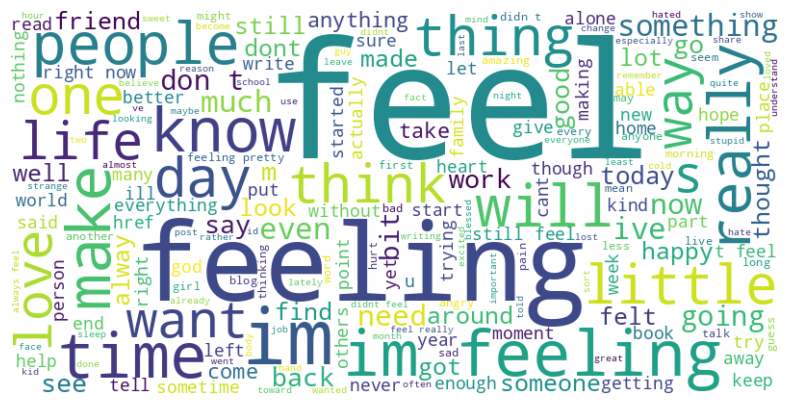

In [ ]:
#plotting most frequently repeated words
text = ' '.join(df["Tweet"])

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

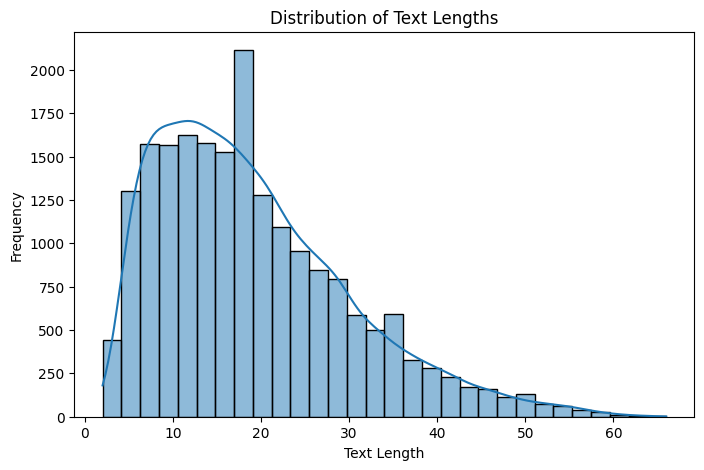

In [ ]:
lengths = [len(text.split()) for text in df["Tweet"]]

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#Checking number of stop words in each row
nltk.download('stopwords')
df_stop =df.copy()
stop_words = set(stopwords.words("english"))
df_stop['stop_words'] = df_stop['Tweet'].apply(lambda x: len(set(x.split()) & set(stop_words)))
print(df_stop['stop_words'])

0         1
1        10
2         3
3         9
4         2
         ..
19995    11
19996    10
19997     9
19998    10
19999     6
Name: stop_words, Length: 20000, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Cleaning

In [ ]:
# Removing duplicated rows
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df = df.drop_duplicates(subset=['Tweet'])
df.duplicated(subset=["Tweet"]).sum()

0

In [ ]:
df.shape

(19948, 2)

In [ ]:
X = df["Tweet"]
y = df["Emotion"]

In [ ]:
import string

def remove_punctuation(sentence):
    # Removing punctuation using string.punctuation
    translator = str.maketrans("", "", string.punctuation)
    sentence_without_punctuation = sentence.translate(translator)
    return sentence_without_punctuation

def remove_special_characters(sentence):
    # Removing a set of special characters
    special_characters = "!@#$%^&*()_+{}[]|;:,.<>?/"
    for char in special_characters:
        sentence = sentence.replace(char, "")
    return sentence

def remove_numbers(sentence):
    # Removing numbers using regular expression
    sentence_without_numbers = re.sub(r'\d+', '', sentence)
    return sentence_without_numbers

def remove_urls(sentence):
    # Using regular expression to remove URLs
    sentence_without_urls = re.sub(r'http[s]?://\S+', '', sentence)
    return sentence_without_urls

X = X.apply(remove_punctuation)
X = X.apply(remove_special_characters)
X = X.apply(remove_numbers)
X = X.apply(remove_urls)
print(X)

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
19995    im having ssa examination tomorrow in the morn...
19996    i constantly worry about their fight against n...
19997    i feel its important to share this info for th...
19998    i truly feel that if you are passionate enough...
19999    i feel like i just wanna buy any cute make up ...
Name: Tweet, Length: 19948, dtype: object


In [ ]:
#Removing stop words
nltk.download('punkt_tab')
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(sentence)
    words_without_stop_words = [word for word in words if word.lower() not in stop_words]
    sentence_without_stop_words = ' '.join(words_without_stop_words)
    return sentence_without_stop_words

X = X.apply(remove_stop_words)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
nltk.download('wordnet')
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    words = sentence.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words ]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

X_cleaned = X.apply(lemmatize_sentence)
print(X_cleaned)

[nltk_data] Downloading package wordnet to /root/nltk_data...


0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
19995    im ssa examination tomorrow morning im quite w...
19996    constantly worry fight nature push limit inner...
19997           feel important share info experience thing
19998    truly feel passionate enough something stay tr...
19999    feel like wan na buy cute make see online even...
Name: Tweet, Length: 19948, dtype: object


In [ ]:
vectorizer = TfidfVectorizer()
X_P = vectorizer.fit_transform(X_cleaned)

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#class mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)

# Print the encoded data
print("Encoded Data:", y)

Class Mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
Encoded Data: [4 4 0 ... 2 2 2]


In [ ]:
# Splitting the data into training (80%) and temporary set (20%)
X_train_lstm, X_temp, y_train_lstm, y_temp = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Further splitting the temporary set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
#encoding
y_train = to_categorical(y_train_lstm)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
# Tokenizing and padding sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Loading GloVe embeddings
glove_file = '/content/drive/MyDrive/glove.twitter.27B.100d.txt'
embedding_dim = 100

embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Creating an embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# LSTM (Long Short-Term Memory)

In [ ]:
# Building the LSTM model
!pip install tensorflow
import tensorflow as tf
with tf.device('/GPU:0'):
  model = Sequential()
  model.add(Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64))
  model.add(Dense(6, activation='softmax'))

# Compiling the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

# Training the model
  model.fit(X_train_pad, y_train, epochs=15, batch_size = 32, validation_data=(X_val_pad, y_val))

# Evaluating the model on the test set
  loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5085 - loss: 1.3080 - val_accuracy: 0.7634 - val_loss: 0.6566
Epoch 2/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7878 - loss: 0.5905 - val_accuracy: 0.8832 - val_loss: 0.3608
Epoch 3/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8827 - loss: 0.3239 - val_accuracy: 0.9113 - val_loss: 0.2614
Epoch 4/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9159 - loss: 0.2227 - val_accuracy: 0.9088 - val_loss: 0.2381
Epoch 5/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9334 - loss: 0.1698 - val_accuracy: 0.9158 - val_loss: 0.2339
Epoch 6/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9410 - loss: 0.1381 - val_accuracy: 0.9253 - val_loss: 0.1994
Epoch 7/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9496 - loss: 0.1170 - val_accuracy: 0.9143 - val_loss: 0.2486
Epoch 8/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9565 - loss: 0.0963 - val_a

In [ ]:
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Evaluation of the model
LSTM_accuracy = accuracy_score(true_labels, predicted_labels)
LSTM_f1score = f1_score(true_labels,predicted_labels,average='macro')
print("Accuracy: ",LSTM_accuracy)
print("f1 score: ",LSTM_f1score)
print()
print(classification_report(true_labels, predicted_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy:  0.9363408521303258
f1 score:  0.9008831870970001

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       303
           1       0.88      0.87      0.88       221
           2       0.96      0.96      0.96       656
           3       0.87      0.87      0.87       170
           4       0.96      0.98      0.97       587
           5       0.78      0.81      0.80        58

    accuracy                           0.94      1995
   macro avg       0.90      0.90      0.90      1995
weighted avg       0.94      0.94      0.94      1995



In [ ]:
#plotting confusion matrix
cf_matrix = confusion_matrix(true_labels,predicted_labels)
print(cf_matrix)

[[279  11   0   0  12   1]
 [  8 192   1   0   9  11]
 [  1   1 628  22   3   1]
 [  0   0  22 148   0   0]
 [  3   5   4   1 574   0]
 [  0   8   2   0   1  47]]


In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
import tensorflow as tf
# Create the model with GPU support
with tf.device('/GPU:0'):
  model = Sequential()
  model.add(Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))

  # Bi-LSTM layer with 64 units
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Flatten())
  model.add(Dense(6, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))

  # Evaluate the model on the test set
  loss, accuracy = model.evaluate(X_test_pad, y_test)
  print(f'Test Accuracy: {accuracy * 100:.2f}%')

  predictions = model.predict(X_test_pad)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_test, axis=1)

  # Evaluation of the model
  BI_LSTM_accuracy = accuracy_score(true_labels, predicted_labels)
  BI_LSTM_f1score = f1_score(true_labels,predicted_labels,average='macro')
  print("Accuracy: ",BI_LSTM_accuracy)
  print("f1 score: ",BI_LSTM_f1score)
  print()
  print(classification_report(true_labels, predicted_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


499/499 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5348 - loss: 1.2490 - val_accuracy: 0.7644 - val_loss: 0.6645
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7857 - loss: 0.5972 - val_accuracy: 0.8501 - val_loss: 0.4325
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8697 - loss: 0.3678 - val_accuracy: 0.8767 - val_loss: 0.3468
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9115 - loss: 0.2378 - val_accuracy: 0.8827 - val_loss: 0.3218
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9398 - loss: 0.1614 - val_accuracy: 0.8892 - val_loss: 0.3170
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9529 - loss: 0.1219 - val_accuracy: 0.8962 - val_loss: 0.3087
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9655 - loss: 0.0900 - val_accuracy: 0.8937 - val_loss: 0.3143
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9759 - loss: 0.0643 - val_accuracy: 

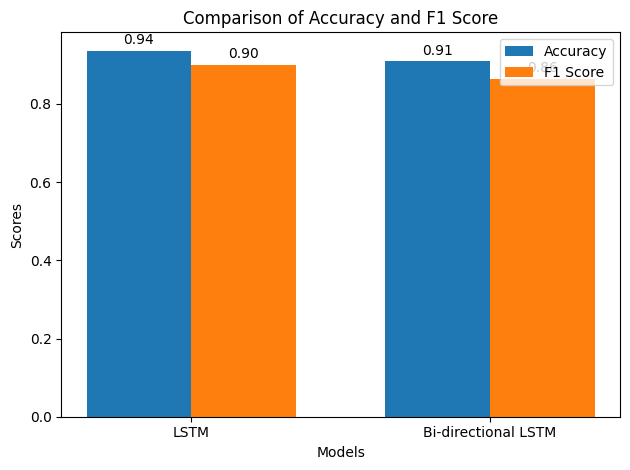

In [ ]:
model_names = ['LSTM', 'Bi-directional LSTM']
accuracy_scores = [LSTM_accuracy, BI_LSTM_accuracy]
f1_scores = [LSTM_f1score, BI_LSTM_f1score]

# Bar width
bar_width = 0.35

# Setting up positions for bars
index = np.arange(len(model_names))
bar1_positions = index
bar2_positions = index + bar_width

# plotting the bar graph
plt.bar(bar1_positions, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(bar2_positions, f1_scores, width=bar_width, label='F1 Score')

# Adding labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Accuracy and F1 Score')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()

# Adding exact values on top of each bar
for i in range(len(model_names)):
    plt.text(bar1_positions[i], accuracy_scores[i] + 0.01, f'{accuracy_scores[i]:.2f}', ha='center', va='bottom')
    plt.text(bar2_positions[i], f1_scores[i] + 0.01, f'{f1_scores[i]:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


# Conclusion:
### By observing the above results, It can be inferred that LSTM model is more effective than other models as it have more accuracy, and f1 score than other models. Hence, LSTM model is best suitable for emotion analysis and detection.

In [ ]:
data = pd.read_csv('/content/tweets.txt',names=["Tweet","Emotion"],sep=";")

In [ ]:
data

,Tweet,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness
19996,i constantly worry about their fight against n...,joy
19997,i feel its important to share this info for th...,joy
19998,i truly feel that if you are passionate enough...,joy


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encoding labels (Emotion column)
label_encoder = LabelEncoder()
data['Emotion'] = label_encoder.fit_transform(data['Emotion'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Tweet'], data['Emotion'], test_size=0.2, random_state=42)

# Print data shapes
print(f'Training data size: {X_train.shape}, Test data size: {X_test.shape}')


Training data size: (16000,), Test data size: (4000,)


In [ ]:
!pip install tf-keras
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder # importing LabelEncoder
import pandas as pd #importing pandas
from sklearn.model_selection import train_test_split


# Function to encode the text data
def encode_data(tokenizer, texts, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Assuming 'data' is your DataFrame, load it if necessary
data = pd.read_csv('/content/tweets.txt', names=["Tweet", "Emotion"], sep=";")  # loading the dataframe

# Encoding labels (Emotion column)
label_encoder = LabelEncoder() # Initializing label encoder
data['Emotion'] = label_encoder.fit_transform(data['Emotion']) # Fitting and transforming Emotion column

# Split dataset into training and testing sets
# This part is optional if you only need label_encoder for model initialization
X_train, X_test, y_train, y_test = train_test_split(data['Tweet'], data['Emotion'], test_size=0.2, random_state=42)


# Tokenizers and Models for BERT, DistilBERT, and RoBERTa
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Now label_encoder is available here
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Ensure GPU is being used
device = torch.device('cuda')
print(f"Training on device: {device}")

# Use faster tokenizer
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast

bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Reduced batch size for faster execution (use this if memory is constrained)
batch_size = 4

# Function to create Trainer for any model
def train_model(model, tokenizer, X_train, y_train, X_test, y_test, batch_size=8, epochs=3):
    model = model.to(device)

    # Tokenize the data
    train_encodings = encode_data(tokenizer, X_train)
    test_encodings = encode_data(tokenizer, X_test)

    class EmotionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            # Move data to GPU and clone the tensors (REMOVED)
            # item = {key: val[idx].clone().detach().to(device) for key, val in self.encodings.items()}
            # item['labels'] = torch.tensor(self.labels.iloc[idx]).clone().detach().to(device)
            # Instead, just return CPU tensors
            item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels.iloc[idx]).clone().detach()
            return item

        def __len__(self):
            return len(self.labels)

    # Prepare dataset
    train_dataset = EmotionDataset(train_encodings, y_train)
    test_dataset = EmotionDataset(test_encodings, y_test)

    # Define TrainingArguments with mixed precision and reduced evaluation frequency
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy='steps',  # Only evaluate every few steps
        eval_steps=500,  # Evaluate every 500 steps
        fp16=True,  # Mixed precision
        gradient_accumulation_steps=4,  # Optional: Accumulate gradients
        dataloader_pin_memory=False #disable pinning
    )

    # Define Trainer
    trainer = Trainer(
        model=model.to(device),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)
        }
    )

    # Train the model
    trainer.train()
    log_history = trainer.state.log_history
    # Evaluate the model
    eval_result = trainer.evaluate()

    return eval_result, log_history

# Train and evaluate BERT model
bert_results, bert_log_history = train_model(bert_model, bert_tokenizer, X_train, y_train, X_test, y_test, batch_size=batch_size) #assigning the return values
print("BERT Results:", bert_results)

# Train and evaluate DistilBERT model
distilbert_results, distilbert_log_history = train_model(distilbert_model, distilbert_tokenizer, X_train, y_train, X_test, y_test, batch_size=batch_size) #assigning the return values
print("DistilBERT Results:", distilbert_results)

# Train and evaluate RoBERTa model
roberta_results, roberta_log_history = train_model(roberta_model, roberta_tokenizer, X_train, y_train, X_test, y_test, batch_size=batch_size) #assigning the return values
print("RoBERTa Results:", roberta_results)


Training on device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
500,0.355200,0.310988,0.901250
1000,0.217300,0.221639,0.927000
1500,0.170000,0.220049,0.931250
2000,0.143800,0.145673,0.935750
2500,0.148700,0.165760,0.935250
3000,0.036700,0.161756,0.938000


BERT Results: {'eval_loss': 0.16175609827041626, 'eval_accuracy': 0.938, 'eval_runtime': 15.7236, 'eval_samples_per_second': 254.395, 'eval_steps_per_second': 63.599, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.313100,0.304720,0.905000
1000,0.238900,0.217768,0.924750
1500,0.148800,0.205834,0.932750
2000,0.104400,0.181797,0.937500
2500,0.118500,0.170682,0.938250
3000,0.032800,0.167994,0.943500


DistilBERT Results: {'eval_loss': 0.1679944396018982, 'eval_accuracy': 0.9435, 'eval_runtime': 8.909, 'eval_samples_per_second': 448.984, 'eval_steps_per_second': 112.246, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.376500,0.394441,0.891750
1000,0.334400,0.274540,0.916000
1500,0.200400,0.249864,0.924000
2000,0.133900,0.207603,0.934250
2500,0.109300,0.192617,0.928250
3000,0.073900,0.196570,0.938500


RoBERTa Results: {'eval_loss': 0.19656991958618164, 'eval_accuracy': 0.9385, 'eval_runtime': 15.8476, 'eval_samples_per_second': 252.403, 'eval_steps_per_second': 63.101, 'epoch': 3.0}


In [ ]:
# Compare results
print(f'BERT Accuracy: {bert_results["eval_accuracy"]}')
print(f'DistilBERT Accuracy: {distilbert_results["eval_accuracy"]}')
print(f'RoBERTa Accuracy: {roberta_results["eval_accuracy"]}')

BERT Accuracy: 0.938
DistilBERT Accuracy: 0.9435
RoBERTa Accuracy: 0.9385


In [ ]:
def plot_comparison_loss_curves(bert_log_history, distilbert_log_history, roberta_log_history):
    # Extract the loss values and steps for each model
    bert_train_losses = [log['loss'] for log in bert_log_history if 'loss' in log]
    bert_eval_losses = [log['eval_loss'] for log in bert_log_history if 'eval_loss' in log]
    # Get steps for both training and eval loss
    bert_train_steps = [log['step'] for log in bert_log_history if 'loss' in log]
    bert_eval_steps = [log['step'] for log in bert_log_history if 'eval_loss' in log]

    distilbert_train_losses = [log['loss'] for log in distilbert_log_history if 'loss' in log]
    distilbert_eval_losses = [log['eval_loss'] for log in distilbert_log_history if 'eval_loss' in log]
    # Get steps for both training and eval loss
    distilbert_train_steps = [log['step'] for log in distilbert_log_history if 'loss' in log]
    distilbert_eval_steps = [log['step'] for log in distilbert_log_history if 'eval_loss' in log]


    roberta_train_losses = [log['loss'] for log in roberta_log_history if 'loss' in log]
    roberta_eval_losses = [log['eval_loss'] for log in roberta_log_history if 'eval_loss' in log]
    # Get steps for both training and eval loss
    roberta_train_steps = [log['step'] for log in roberta_log_history if 'loss' in log]
    roberta_eval_steps = [log['step'] for log in roberta_log_history if 'eval_loss' in log]


    # Plotting all models in a single plot for comparison
    plt.figure(figsize=(12, 8))

    # Use corresponding steps for each loss type
    plt.plot(bert_train_steps, bert_train_losses, label='BERT Training Loss', color='blue')
    plt.plot(bert_eval_steps, bert_eval_losses, label='BERT Evaluation Loss', color='red')

    plt.plot(distilbert_train_steps, distilbert_train_losses, label='DistilBERT Training Loss', color='green')
    plt.plot(distilbert_eval_steps, distilbert_eval_losses, label='DistilBERT Evaluation Loss', color='orange')

    plt.plot(roberta_train_steps, roberta_train_losses, label='RoBERTa Training Loss', color='purple')
    plt.plot(roberta_eval_steps, roberta_eval_losses, label='RoBERTa Evaluation Loss', color='yellow')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Model Loss Comparison (BERT, DistilBERT, RoBERTa)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print(bert_log_history[:5])  # Check first 5 entries of BERT log history
print(distilbert_log_history[:5])  # Check first 5 entries of DistilBERT log history
print(roberta_log_history[:5])  # Check first 5 entries of RoBERTa log history


[{'loss': 1.8312, 'grad_norm': 26.770057678222656, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.01, 'step': 10}, {'loss': 1.8505, 'grad_norm': 27.47317886352539, 'learning_rate': 1.8e-06, 'epoch': 0.02, 'step': 20}, {'loss': 1.8164, 'grad_norm': 23.16036605834961, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.03, 'step': 30}, {'loss': 1.7764, 'grad_norm': 22.361507415771484, 'learning_rate': 3.8e-06, 'epoch': 0.04, 'step': 40}, {'loss': 1.7605, 'grad_norm': 18.95501708984375, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.05, 'step': 50}]
[{'loss': 1.8074, 'grad_norm': 9.572705268859863, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01, 'step': 10}, {'loss': 1.8029, 'grad_norm': 9.988222122192383, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02, 'step': 20}, {'loss': 1.8082, 'grad_norm': 8.742557525634766, 'learning_rate': 3e-06, 'epoch': 0.03, 'step': 30}, {'loss': 1.7803, 'grad_norm': 7.829075813293457, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.0

In [ ]:
# Instead of using __code__.co_consts, directly call the nested function:
def extract_losses_and_steps(log_history):
    train_losses = [log['loss'] for log in log_history if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    steps = [log['step'] for log in log_history if 'loss' in log]
    return train_losses, eval_losses, steps

# Now you can use the function:
bert_train_losses, bert_eval_losses, bert_steps = extract_losses_and_steps(bert_log_history)
distilbert_train_losses, distilbert_eval_losses, distilbert_steps = extract_losses_and_steps(distilbert_log_history)
roberta_train_losses, roberta_eval_losses, roberta_steps = extract_losses_and_steps(roberta_log_history)

# Print the losses outside the function
print("BERT Train Losses:", bert_train_losses)
print("DistilBERT Train Losses:", distilbert_train_losses)
print("RoBERTa Train Losses:", roberta_train_losses)

BERT Train Losses: [1.8312, 1.8505, 1.8164, 1.7764, 1.7605, 1.7333, 1.7159, 1.6571, 1.6047, 1.5728, 1.5148, 1.4873, 1.4561, 1.3659, 1.4691, 1.3271, 1.2748, 1.175, 1.0627, 1.0295, 1.0985, 1.19, 1.0877, 0.9689, 1.0165, 1.026, 0.8145, 0.8047, 0.7109, 0.8667, 0.6523, 0.5505, 0.4933, 0.5405, 0.6665, 0.5397, 0.3638, 0.4095, 0.4327, 0.4778, 0.4764, 0.4623, 0.3651, 0.3632, 0.3999, 0.3738, 0.3545, 0.4072, 0.3044, 0.3552, 0.2549, 0.33, 0.3896, 0.4711, 0.1724, 0.5071, 0.396, 0.264, 0.4294, 0.3813, 0.3826, 0.2785, 0.3656, 0.2541, 0.2231, 0.3559, 0.4308, 0.2702, 0.387, 0.3815, 0.28, 0.2443, 0.0818, 0.3129, 0.2059, 0.2394, 0.2465, 0.2965, 0.2856, 0.2173, 0.208, 0.3655, 0.2826, 0.1572, 0.3362, 0.1819, 0.1123, 0.3769, 0.3725, 0.1444, 0.5306, 0.2618, 0.1403, 0.2956, 0.2685, 0.3499, 0.3071, 0.3225, 0.2882, 0.2173, 0.2157, 0.2272, 0.1623, 0.16, 0.2166, 0.1761, 0.2224, 0.4569, 0.1861, 0.1379, 0.097, 0.3856, 0.1912, 0.1917, 0.1817, 0.369, 0.1719, 0.2792, 0.1376, 0.2585, 0.1539, 0.1644, 0.1865, 0.1842, 0.23

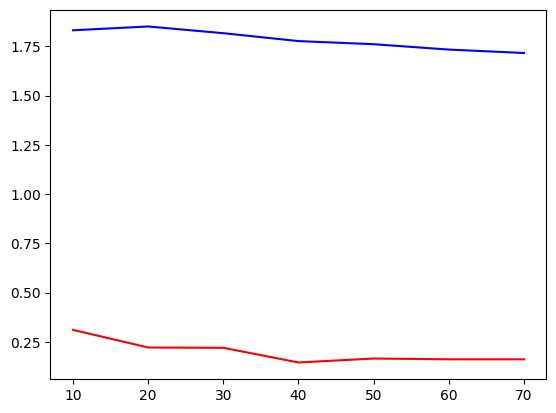

In [ ]:
# Limit the range of bert_steps to match bert_eval_losses
plt.plot(bert_steps[:len(bert_eval_losses)], bert_train_losses[:len(bert_eval_losses)], label='BERT Training Loss', color='blue')
plt.plot(bert_steps[:len(bert_eval_losses)], bert_eval_losses, label='BERT Evaluation Loss', color='red')

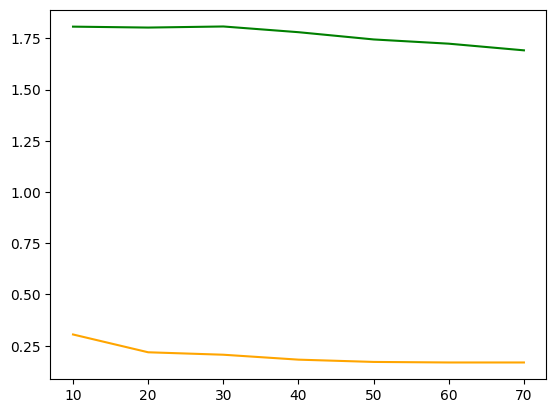

In [ ]:
    plt.plot(distilbert_steps[:len(distilbert_eval_losses)], distilbert_train_losses[:len(distilbert_eval_losses)], label='DistilBERT Training Loss', color='green')
    plt.plot(distilbert_steps[:len(distilbert_eval_losses)], distilbert_eval_losses, label='DistilBERT Evaluation Loss', color='orange')

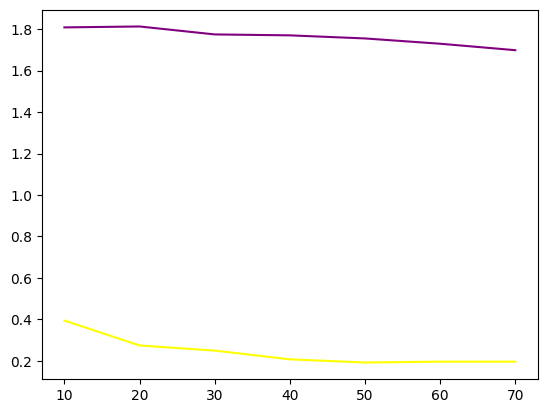

In [ ]:
    plt.plot(roberta_steps[:len(roberta_eval_losses)], roberta_train_losses[:len(roberta_eval_losses)], label='RoBERTa Training Loss', color='purple')
    plt.plot(roberta_steps[:len(roberta_eval_losses)], roberta_eval_losses, label='RoBERTa Evaluation Loss', color='yellow')

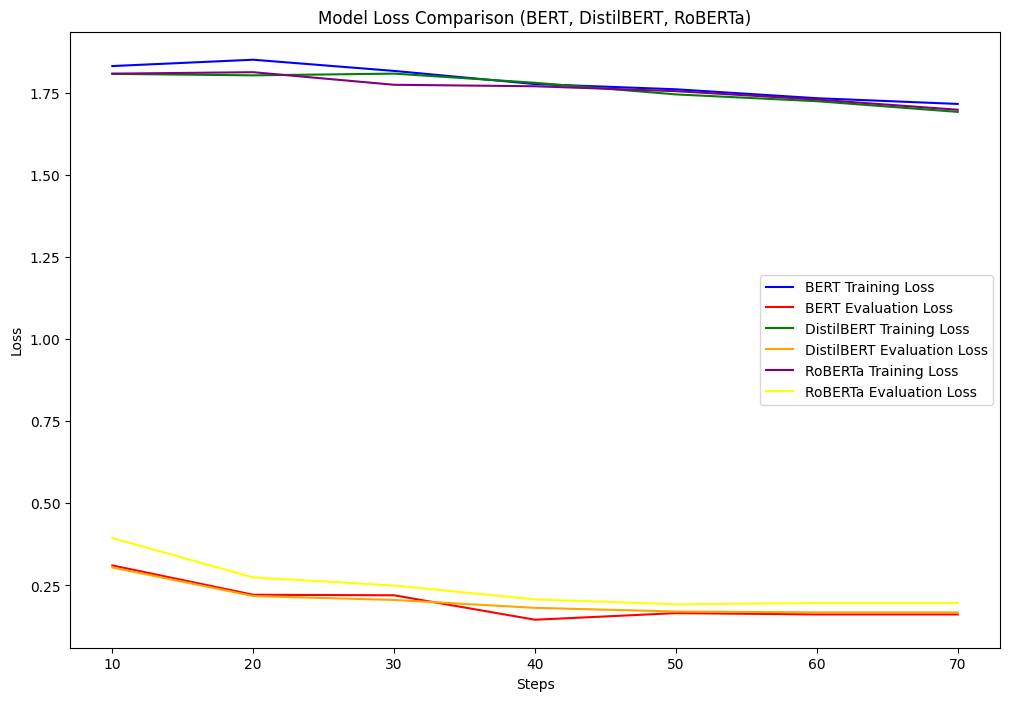

In [ ]:
# Plotting all models in a single plot for comparison
    plt.figure(figsize=(12, 8))

    # BERT Training and Evaluation Losses
    plt.plot(bert_steps[:len(bert_eval_losses)], bert_train_losses[:len(bert_eval_losses)], label='BERT Training Loss', color='blue')
    plt.plot(bert_steps[:len(bert_eval_losses)], bert_eval_losses, label='BERT Evaluation Loss', color='red')

    # DistilBERT Training and Evaluation Losses
    plt.plot(distilbert_steps[:len(distilbert_eval_losses)], distilbert_train_losses[:len(distilbert_eval_losses)], label='DistilBERT Training Loss', color='green')
    plt.plot(distilbert_steps[:len(distilbert_eval_losses)], distilbert_eval_losses, label='DistilBERT Evaluation Loss', color='orange')

    # RoBERTa Training and Evaluation Losses
    plt.plot(roberta_steps[:len(roberta_eval_losses)], roberta_train_losses[:len(roberta_eval_losses)], label='RoBERTa Training Loss', color='purple')
    plt.plot(roberta_steps[:len(roberta_eval_losses)], roberta_eval_losses, label='RoBERTa Evaluation Loss', color='yellow')

    # Set labels and title
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Model Loss Comparison (BERT, DistilBERT, RoBERTa)')

    # Add a legend to differentiate the curves
    plt.legend()

    # Show the plot
    plt.show()


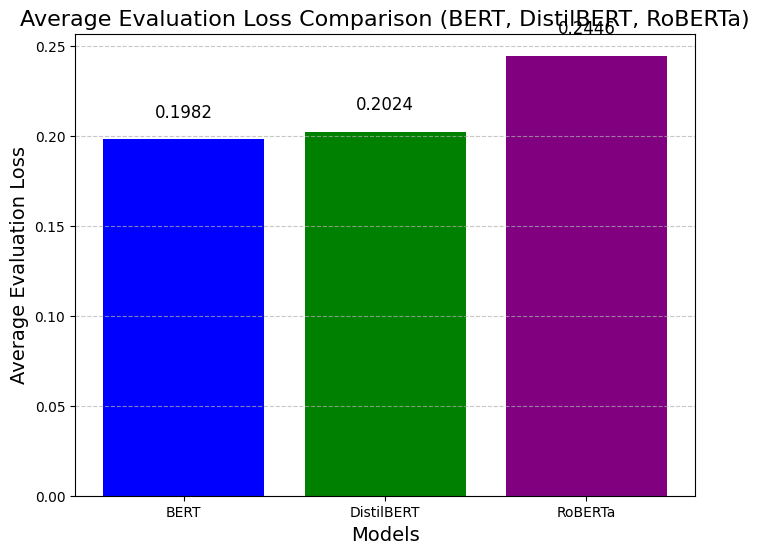

In [ ]:
def plot_average_loss_comparison(bert_eval_losses, distilbert_eval_losses, roberta_eval_losses):
    # Calculate average losses for each model
    bert_avg_loss = np.mean(bert_eval_losses)
    distilbert_avg_loss = np.mean(distilbert_eval_losses)
    roberta_avg_loss = np.mean(roberta_eval_losses)

    # Models' names for the x-axis labels
    model_names = ['BERT', 'DistilBERT', 'RoBERTa']
    avg_losses = [bert_avg_loss, distilbert_avg_loss, roberta_avg_loss]

    # Plotting the bar chart
    plt.figure(figsize=(8, 6))

    # Create bars for average loss
    bars = plt.bar(model_names, avg_losses, color=['blue', 'green', 'purple'])

    # Adding annotations (average loss values on top of the bars)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

    # Set labels and title
    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Average Evaluation Loss', fontsize=14)
    plt.title('Average Evaluation Loss Comparison (BERT, DistilBERT, RoBERTa)', fontsize=16)

    # Show grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

# Example usage
# Assuming the `bert_eval_losses`, `distilbert_eval_losses`, and `roberta_eval_losses` lists are already available
plot_average_loss_comparison(bert_eval_losses, distilbert_eval_losses, roberta_eval_losses)
